In [5]:
#f(x) = a*x + b
#f(-1) = lb, f(1) = ub
#-a + b = lb
#a + b = ub
#2*b = lb + ub
#b = (lb + ub)/2
#a = ub - lb/2 - ub/2 = (ub - lb)/2
#(ub-lb)/2*x + (lb+ub)/2
#

In [6]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
import sys
sys.path.append('..')
import functools
import math
import collections

import numpy as np
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import sobol_seq
import scipy.stats

from bvbq import distributions,utils
from bvbq import BVBQMixMVN

In [8]:
scipy.stats.gamma(1.0).rvs(size=(10,1))

array([[0.26517091],
       [0.58823861],
       [0.12989515],
       [0.70461537],
       [0.56696498],
       [2.03405416],
       [0.45749956],
       [0.54800206],
       [0.46271227],
       [0.30468366]])

In [9]:
def loggaussian(x,mu,sigma):
    return -0.5*((x-mu)/sigma)**2 - np.log(np.sqrt(2*np.pi)*sigma)

def baselogprob(params):
    mu,sigma = params['mu'],params['sigma']
    term1 = np.log(scipy.stats.gamma(5.0).pdf(sigma))
    term2 = loggaussian(mu,0,sigma)
    return term1 + term2

def basesample(n):
    sigma = scipy.stats.gamma(5.0).rvs(size=(n,1))
    mu = np.random.randn(n,1)*sigma
    res = {'mu':mu,'sigma':sigma}
    return res


(0.0, 12.99083998724324)

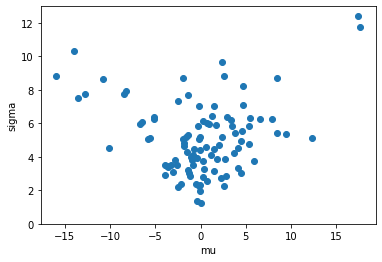

In [10]:
fig = plt.figure()
ax = fig.add_subplot(111)
samples = basesample(100)
ax.scatter(samples['mu'],samples['sigma'])
ax.set_xlabel('mu')
ax.set_ylabel('sigma')
ax.set_ylim(bottom=0.0)

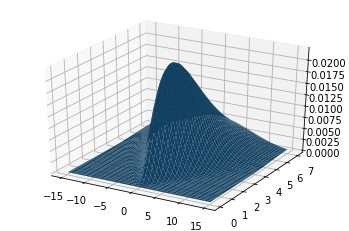

In [88]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

sigma_plot,mu_plot = np.meshgrid(np.linspace(0,7,101)[1:],np.linspace(-15,15))
params = {'mu':mu_plot,'sigma':sigma_plot}
zplot = baselogprob(params)
ax.plot_surface(mu_plot,sigma_plot,np.exp(zplot))

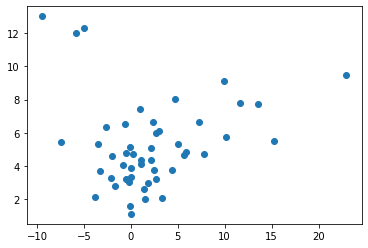

In [94]:
ndata = 50
sigma = scipy.stats.gamma(5).rvs(size=(ndata,1))
mu = np.random.randn(ndata,1)*sigma
plt.scatter(mu,sigma)

In [95]:
bvbq = BVBQMixMVN(['mu','sigma'],[1,1],[(None,None),(0.0,None)])

In [96]:
params_init = {'mu':mu,'sigma':sigma}
params_evals = baselogprob(params_init)
bvbq.initialize_data(params_init,params_evals,empirical_params=True)
bvbq.initialize_components()

In [97]:
# for i in range(5):
#     params = bvbq.new_evaluation_point()
#     evals = baselogprob(params)
#     bvbq.insert_new_evaluations(params,evals)

If tensor has more than 2 dimensions, only diagonal of covariance is returned


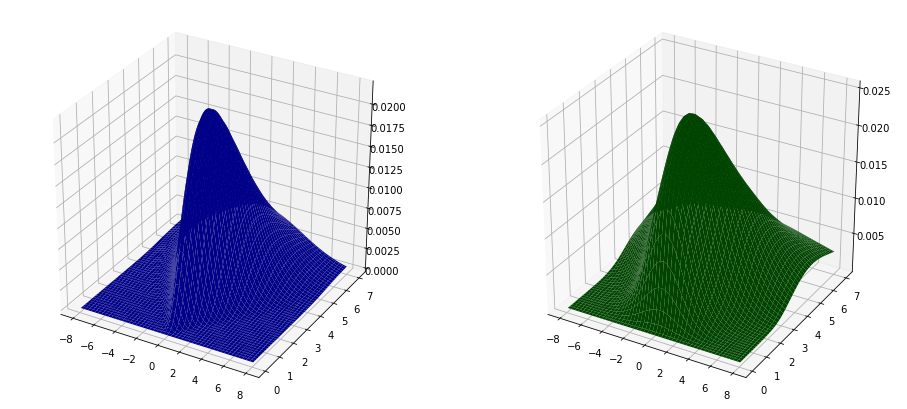

In [98]:
fig = plt.figure(figsize=(16,16))
ax1 = fig.add_subplot(221,projection='3d')
ax3 = fig.add_subplot(222,projection='3d')
sigma_plot,mu_plot = np.meshgrid(np.linspace(0,7,101)[1:],np.linspace(-8,8))
zplot3 = baselogprob({'mu':mu_plot,'sigma':sigma_plot})
zplot3 = bvbq.surrogate_prediction({'mu':mu_plot[...,None],'sigma':sigma_plot[...,None]}).numpy()
ax1.plot_surface(mu_plot,sigma_plot,np.exp(zplot),color='blue',alpha=1.0)
ax3.plot_surface(mu_plot,sigma_plot,np.exp(zplot3),color='green',alpha=1.0)

In [99]:
for i in range(50):
    bvbq.update_distribution()

In [100]:
distrib = bvbq.distribution

In [101]:
distrib.sample(1, numpy=True)

{'mu': array([[0.6022776]], dtype=float32),
 'sigma': array([[6.1399565]], dtype=float32)}

In [104]:
distrib.logprob({'mu': [1.0],'sigma': [1.0]}, numpy=True)

array(-4.911644, dtype=float32)

In [105]:
baselogprob({'mu': np.array([1.0]),'sigma': np.array([1.0])})

array([-5.59699236])

Text(0, 0.5, 'sigma')

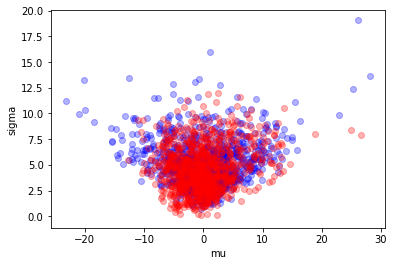

In [106]:
fig = plt.figure()
ax = fig.add_subplot(111)
samples = basesample(1000)
samples_vb = distrib.sample(1000)
ax.scatter(samples['mu'],samples['sigma'],color='blue',alpha=0.3)
ax.scatter(samples_vb['mu'].numpy(),samples_vb['sigma'].numpy(),color='red',alpha=0.3)
ax.set_xlabel('mu')
ax.set_ylabel('sigma')

If tensor has more than 2 dimensions, only diagonal of covariance is returned


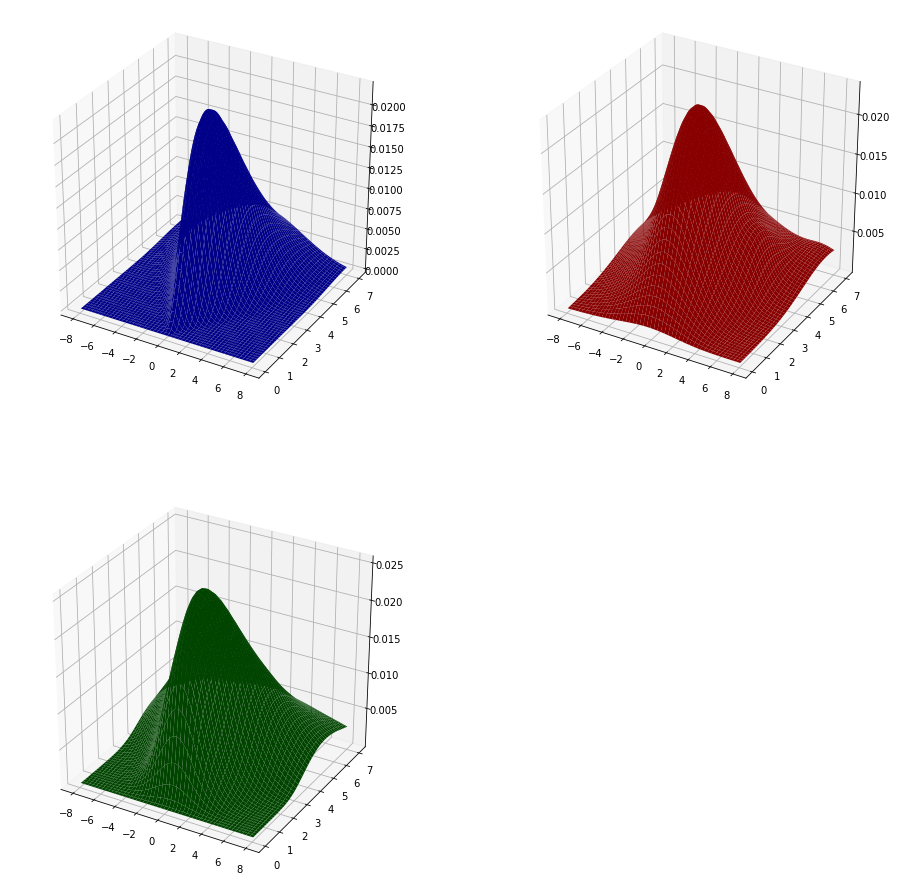

In [107]:
fig = plt.figure(figsize=(16,16))
ax1 = fig.add_subplot(221,projection='3d')
ax2 = fig.add_subplot(222,projection='3d')
ax3 = fig.add_subplot(223,projection='3d')
sigma_plot,mu_plot = np.meshgrid(np.linspace(0,7,101)[1:],np.linspace(-8,8))
zplot3 = baselogprob({'mu':mu_plot,'sigma':sigma_plot})
zplot2 = distrib.logprob({'mu':mu_plot[...,None],'sigma':sigma_plot[...,None]}).numpy()
zplot3 = bvbq.surrogate_prediction({'mu':mu_plot[...,None],'sigma':sigma_plot[...,None]}).numpy()
ax1.plot_surface(mu_plot,sigma_plot,np.exp(zplot),color='blue',alpha=1.0)
ax2.plot_surface(mu_plot,sigma_plot,np.exp(zplot2),color='red',alpha=1.0)
ax3.plot_surface(mu_plot,sigma_plot,np.exp(zplot3),color='green',alpha=1.0)

In [23]:
bvbq.surrogate_prediction({'mu':mu_plot[...,None],'sigma':sigma_plot[...,None]})

If tensor has more than 2 dimensions, only diagonal of covariance is returned


tensor([[-29.9531, -30.6109, -30.9818,  ..., -32.6350, -32.6352, -32.6354],
        [-29.9515, -30.6087, -30.9791,  ..., -32.6257, -32.6260, -32.6264],
        [-29.9488, -30.6051, -30.9747,  ..., -32.6104, -32.6109, -32.6113],
        ...,
        [-29.9524, -30.6100, -30.9805,  ..., -32.6271, -32.6274, -32.6276],
        [-29.9536, -30.6117, -30.9826,  ..., -32.6358, -32.6360, -32.6361],
        [-29.9543, -30.6127, -30.9838,  ..., -32.6409, -32.6411, -32.6412]])